In [14]:
from scipy.io import loadmat, savemat
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import vlkit.plt as vlplt
import pydicom
import os.path as osp
import time, sys
from utils import write_dicom, write_dicom_meta
import torch
import numpy as np
from pharmacokinetic import parker_aif, fit_slice, process_patient, get_ct_curve, np2torch

In [15]:
device = torch.device('cpu')
data = loadmat('../tmp/patient-0.mat')
data = np2torch(data)

t = (data['time_dce'] / 60).to(device=device)
aif_t = torch.arange(0, t[-1].item(), 1/60, dtype=torch.float64).to(t)

hct = 0.42
aif_cp = parker_aif(
    a1=0.809, a2=0.330,
    t1=0.17046, t2=0.365,
    sigma1=0.0563, sigma2=0.132,
    alpha=1.050, beta=0.1685, s=38.078, tau=0.483,
    t=aif_t - (t[int(data['maxBase'].item())-1] * 60).ceil() / 60
    ) / (1 - hct)

In [16]:
aif_cp.dtype

torch.float32

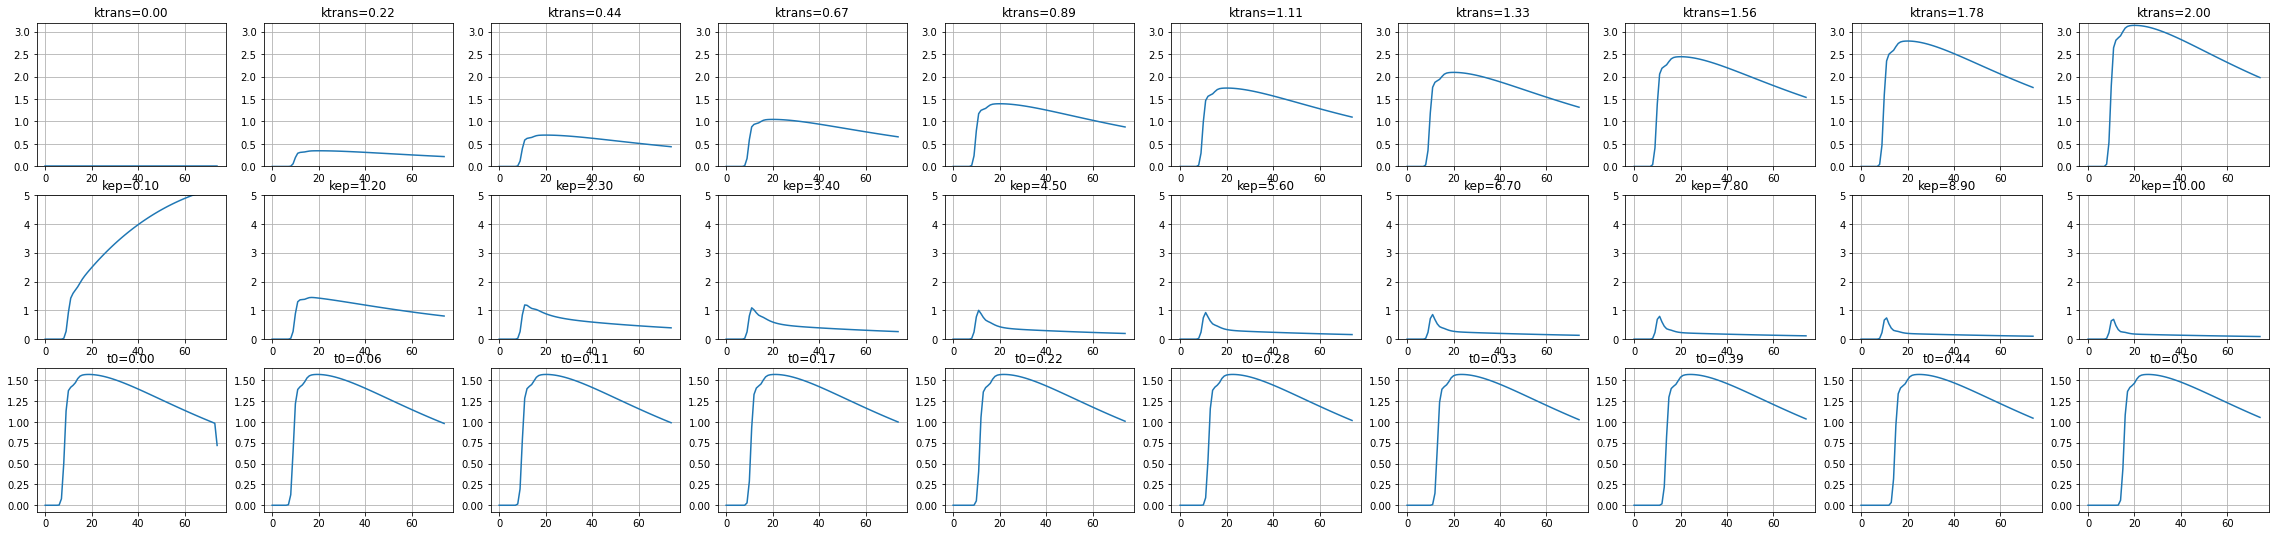

In [48]:
n = 10
fig, axes = plt.subplots(3, n, figsize=(n*4, 3*3))

# vlplt.clear_ticks(axes)


for idx, i in enumerate(np.linspace(0, 2, n)):
    curve = get_ct_curve(params=torch.tensor([i, 1, 0.1], dtype=torch.float), t=t, aif_t=aif_t, aif_cp=aif_cp)
    axes[0, idx].plot(curve)
    axes[0, idx].set_title('ktrans=%.2f' % i)
    axes[0, idx].grid(visible=True)
    axes[0, idx].set_ylim(0, 3.2)

for idx, i in enumerate(np.linspace(0.1, 10, n)):
    curve = get_ct_curve(params=torch.tensor([1, i, 0.1], dtype=torch.float), t=t, aif_t=aif_t, aif_cp=aif_cp)
    axes[1, idx].plot(curve)
    axes[1, idx].set_title('kep=%.2f' % i)
    axes[1, idx].grid(visible=True)
    axes[1, idx].set_ylim(0, 5)

for idx, i in enumerate(np.linspace(0, 0.5, n)):
    curve = get_ct_curve(params=torch.tensor([1, 1, i], dtype=torch.float), t=t, aif_t=aif_t, aif_cp=aif_cp)
    axes[2, idx].plot(curve)
    axes[2, idx].set_title('t0=%.2f' % i)
    axes[2, idx].grid(visible=True)
plt.savefig('curves-different-params.pdf')

In [ ]:
data = loadmat('../tmp/patient-0.mat')
kep = data['kep']
n = kep.shape[2]

fig, axes = plt.subplots(2, kep.shape[2], figsize=(2*kep.shape[2], 4))
vlplt.clear_ticks(axes)

for i in range(n):
    kep1 = kep[:, :, i]
    kep1[kep1 > kep1.max()/50] = 0
    axes[0, i].imshow(kep[:, :, i])
    axes[1, i].imshow(kep[60:100, 60:80, i])
plt.savefig('kep.pdf')

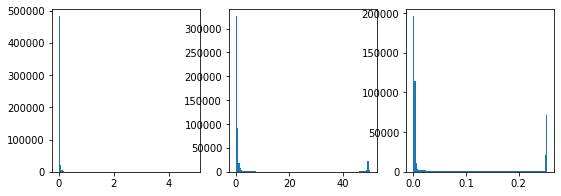

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
a = axes[0].hist(data['ktrans'].flatten(), 100)
a = axes[1].hist(data['kep'].flatten(), 100)
a = axes[2].hist(data['t0'].flatten(), 100)

In [35]:
d = pydicom.dcmread('/data1/home/kzhao/Code/dce-matlab/torch/work_dirs/transformer-8layers-4heads-use_grad-no_loss_scale/dicom/Matlab-kep/slice-000.dcm')

In [36]:
d.SeriesNumber

'33009'

In [37]:
d = pydicom.dcmread('work_dirs/transformer-8layers-4heads-use_grad-no_loss_scale/dicom/tansformer-ktrans/slice-000.dcm')

In [38]:
d.SeriesNumber

'30000'